# Optimization IOU and Confidence over SSD300

In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import json
import os.path

from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

from models.keras_ssd300 import ssd_300
from models.keras_ssd512 import ssd_512
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

from extra_files import helper

%matplotlib inline

## 1. Load a trained SSD

### Build the model and load trained weights into it wih parameters confidence and iou threshold

In [22]:
def load_model(model_path, confidence_thresh, iou_threshold):
    '''
    model_path: path to the weight's model
    conficence_thresh: confidence threshold needed to keep a predition
    iou: iou threshold to remove multiple bounding boxes
    return keras model
    '''
    # 1: Build the Keras model
    K.clear_session() # Clear previous models from memory.

    model = ssd_300(image_size=(300, 300, 3),
                    n_classes=20,
                    mode='inference',
                    l2_regularization=0.0005,
                    scales=[0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05], # The scales for MS COCO are [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                    aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                             [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                             [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                             [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                             [1.0, 2.0, 0.5],
                                             [1.0, 2.0, 0.5]],
                    two_boxes_for_ar1=True,
                    steps=[8, 16, 32, 64, 100, 300],
                    offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                    clip_boxes=False,
                    variances=[0.1, 0.1, 0.2, 0.2],
                    normalize_coords=True,
                    subtract_mean=[123, 117, 104],
                    swap_channels=[2, 1, 0],
                    confidence_thresh=confidence_thresh,
                    iou_threshold=iou_threshold,
                    top_k=9000,
                    nms_max_output_size=9000)

    # 2: Load the trained weights into the model.
    # TODO: Set the path of the trained weights.
    model.load_weights(model_path, by_name=True)

    # 3: Compile the model so that Keras won't complain the next time you load it.

    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    return model

  ## 2. Load Images

Load some images for which you'd like the model to make predictions.

In [23]:
path_root = '/home/aldopedraza/Documentos/data-cic/preprocess_data'
path_save = path_root + '/predictions/'
train_img = np.load(path_root + '/images_train_300x300.npy')

## 3. Make predictions

In [24]:
model_pascal_voc_07_plus_12_300x300 = '../weights/pascal_voc/pascal_voc_07_plus_12_300x300.h5'

In [25]:
def get_predictions(path_model, batch_size, images_list, confidence, iou):
    '''
    Make predictions from a model
    path_model: the path to the weights' model
    batch_size: size of the batch
    images_list: list of images to make predictions
    confidence: confidence threshold
    iou: iou threshold
    return predictions
    '''
    # Create variable to store predictions
    predictions = np.zeros(shape=(1, 9000, 6))
    
    model = load_model(path_model, confidence, iou)

    for batch in helper.get_batch(batch_size, images_list):
        predictions = np.append(predictions, model.predict(batch), axis=0)
    predictions = predictions[1:] # delete empty item

    clean_pre = helper.clean_predictions(predictions)
    adjust_pre = helper.adjust_predictions(clean_pre)
    K.clear_session()
    return adjust_pre

In [26]:
# Make predictions of the models
# 07++12
predictions_list = []
confidence_list = np.arange(0.0, 1.05, 0.05)
iou_list= np.arange(0.0, 1.05, 0.05)

columns = ['Conficence', 'IOU', 'Predictions']

for conf in confidence_list:
    for iou in iou_list:
        print('Predictions with confidence: ', conf, ' iou: ', iou)
        start = time.time()

        pred = get_predictions(model_pascal_voc_07_plus_12_300x300, 8, train_img, conf.item(), iou.item())
        predictions_list.append([conf, iou, pred])
        
        end = time.time()
        print(round(end - start, 4))

predictions_list = np.array(predictions_list)

# Create DataFrame with all predictions
pred_data = pd.DataFrame(predictions_list, columns=columns)
pred_data.to_csv(path_save + 'optimization_pred.csv')

Predictions with confidence:  0.0  iou:  0.0
10.8492
Predictions with confidence:  0.0  iou:  0.05
10.7386
Predictions with confidence:  0.0  iou:  0.1
10.9561
Predictions with confidence:  0.0  iou:  0.15000000000000002
11.0223
Predictions with confidence:  0.0  iou:  0.2
11.2622
Predictions with confidence:  0.0  iou:  0.25
11.5953
Predictions with confidence:  0.0  iou:  0.30000000000000004
12.0215
Predictions with confidence:  0.0  iou:  0.35000000000000003
12.4786
Predictions with confidence:  0.0  iou:  0.4
13.5436
Predictions with confidence:  0.0  iou:  0.45
14.4861
Predictions with confidence:  0.0  iou:  0.5
15.9266
Predictions with confidence:  0.0  iou:  0.55
17.7832
Predictions with confidence:  0.0  iou:  0.6000000000000001
21.0987
Predictions with confidence:  0.0  iou:  0.65
25.1975
Predictions with confidence:  0.0  iou:  0.7000000000000001
30.3437
Predictions with confidence:  0.0  iou:  0.75
36.0038
Predictions with confidence:  0.0  iou:  0.8
39.2485
Predictions wit

## Some predictions with different confidence and iou

In [53]:
preds = helper.get_coordinates(pred_data.iloc[200]['Predictions'])

In [54]:
one_pred = helper.normilize_to_pixel(preds, 300, 300)

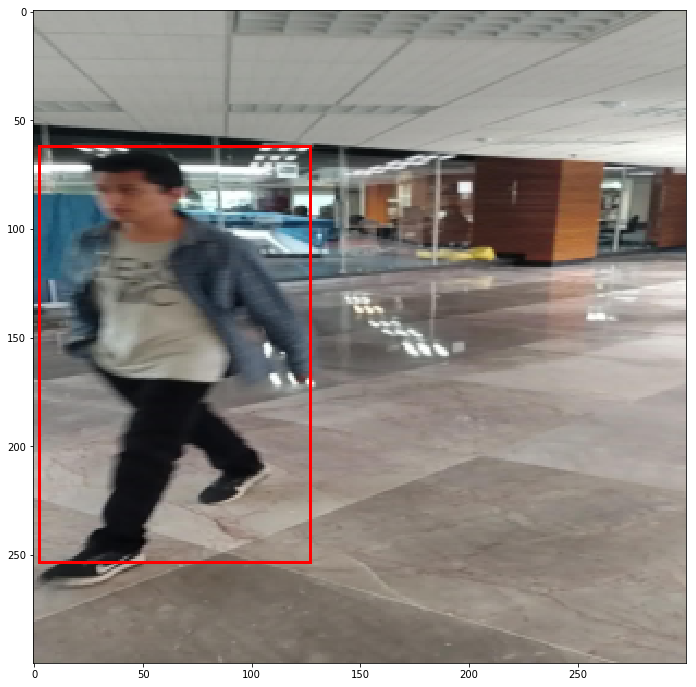

In [56]:
helper.show_image_bb(train_img[115], one_pred[115])

## Search for optimal parameters by calculating f1 score

In [58]:
label_training = np.load(path_root + '/label_train.npy')

In [86]:
# Iterate over all predictions and calculate the metrics
performance = []

for idx_pred in list(range(pred_data.shape[0])):
    print('Calculating metrics for:', idx_pred + 1, 'from:', pred_data.shape[0])
    
    pred = pred_data.iloc[idx_pred]['Predictions']
    pred = helper.get_coordinates(pred)
    confidence = pred_data.iloc[idx_pred]['Conficence']
    iou = pred_data.iloc[idx_pred]['IOU']
    # Calculate metrics
    presicion, recall, f1_score = helper.cal_performance(label_training, pred, False)
    performance.append([confidence, iou, presicion, recall, f1_score])

# Create DataFrame with all metrics
columns = ['Confidence', 'IOU', 'Presicion', 'Recall', 'F1 score']
performance_frame = pd.DataFrame(np.array(performance), columns=columns)

Calculating metrics for: 1 from: 441
Calculating metrics for: 2 from: 441
Calculating metrics for: 3 from: 441
Calculating metrics for: 4 from: 441
Calculating metrics for: 5 from: 441
Calculating metrics for: 6 from: 441
Calculating metrics for: 7 from: 441
Calculating metrics for: 8 from: 441
Calculating metrics for: 9 from: 441
Calculating metrics for: 10 from: 441
Calculating metrics for: 11 from: 441
Calculating metrics for: 12 from: 441
Calculating metrics for: 13 from: 441
Calculating metrics for: 14 from: 441
Calculating metrics for: 15 from: 441
Calculating metrics for: 16 from: 441
Calculating metrics for: 17 from: 441
Calculating metrics for: 18 from: 441
Calculating metrics for: 19 from: 441
Calculating metrics for: 20 from: 441
Calculating metrics for: 21 from: 441
Calculating metrics for: 22 from: 441
Calculating metrics for: 23 from: 441
Calculating metrics for: 24 from: 441
Calculating metrics for: 25 from: 441
Calculating metrics for: 26 from: 441
Calculating metrics f

In [87]:
performance_frame.head()

Confidence   IOU  Presicion    Recall  F1 score
0         0.0  0.00   0.014166  0.596882  0.027674
1         0.0  0.05   0.012391  0.620320  0.024296
2         0.0  0.10   0.011766  0.636342  0.023104
3         0.0  0.15   0.011825  0.648414  0.023226
4         0.0  0.20   0.012277  0.656203  0.024103

In [88]:
performance_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441 entries, 0 to 440
Data columns (total 5 columns):
Confidence    441 non-null float64
IOU           441 non-null float64
Presicion     441 non-null float64
Recall        441 non-null float64
F1 score      441 non-null float64
dtypes: float64(5)
memory usage: 17.3 KB


In [89]:
performance_frame.describe()

Confidence         IOU   Presicion      Recall    F1 score
count  441.000000  441.000000  441.000000  441.000000  441.000000
mean     0.500000    0.500000    0.650016    0.446393    0.491963
std      0.303109    0.303109    0.223445    0.152296    0.166172
min      0.000000    0.000000    0.000000    0.000000    0.000000
25%      0.250000    0.250000    0.650390    0.377272    0.492315
50%      0.500000    0.500000    0.729880    0.463077    0.550748
75%      0.750000    0.750000    0.773426    0.545713    0.589005
max      1.000000    1.000000    0.841141    0.777113    0.662483

In [160]:
print(performance_frame.iloc[performance_frame['Presicion'].argmax()], end='\n\n')
print(performance_frame.iloc[performance_frame['Recall'].argmax()], end='\n\n')
print(performance_frame.iloc[performance_frame['F1 score'].argmax()], end='\n\n')

Confidence    0.950000
IOU           1.000000
Presicion     0.841141
Recall        0.238598
F1 score      0.371747
Name: 419, dtype: float64

Confidence    0.000000
IOU           1.000000
Presicion     0.032325
Recall        0.777113
F1 score      0.062068
Name: 20, dtype: float64

Confidence    0.150000
IOU           1.000000
Presicion     0.701340
Recall        0.627705
F1 score      0.662483
Name: 83, dtype: float64



/home/aldopedraza/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  if __name__ == '__main__':
/home/aldopedraza/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  from ipykernel import kernelapp as app
/home/aldopedraza/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of

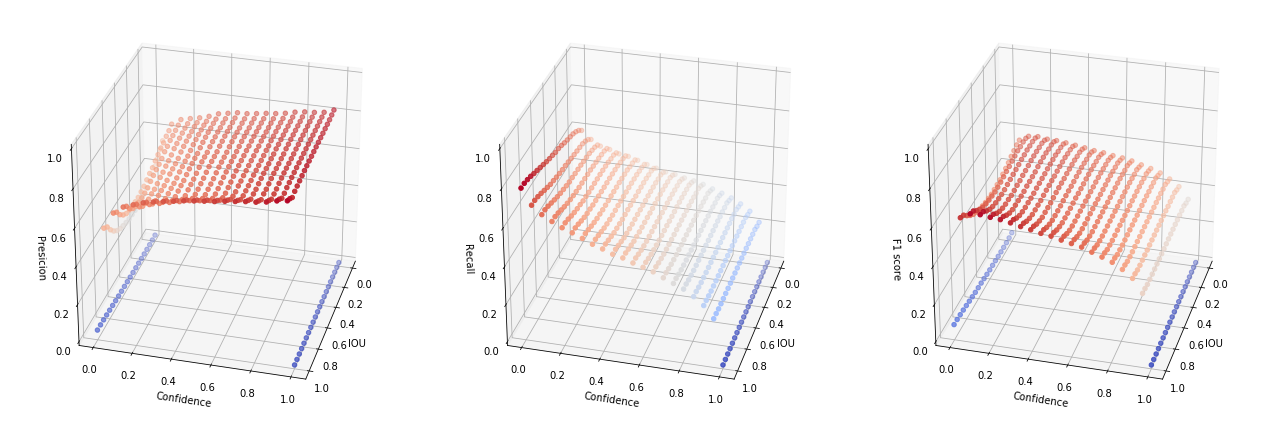

In [152]:
import seaborn as sns
presicion = performance_frame['Presicion']
recall =  performance_frame['Recall']
f1_score = performance_frame['F1 score']
iou = performance_frame['IOU']
confidence = performance_frame['Confidence']

fig = plt.figure(figsize=(18,6))

# fig = plt.figure()
ax = fig.add_subplot(131, projection='3d')
ax.scatter(iou, confidence, presicion, c=presicion, cmap='coolwarm', linewidth=1.0)
ax.set_zlim(0, 1)
ax.set_xlabel('IOU')
ax.set_ylabel('Confidence')
ax.set_zlabel('Presicion')
ax.view_init(30, 15)
# ax.plot_trisurf(iou, confidence, f1_score)

ax = fig.add_subplot(132, projection='3d')
ax.scatter(iou, confidence, recall, c=recall, cmap='coolwarm', linewidth=1.0)
ax.set_zlim(0, 1)
ax.set_xlabel('IOU')
ax.set_ylabel('Confidence')
ax.set_zlabel('Recall')
ax.view_init(30, 15)


ax = fig.add_subplot(133, projection='3d')
ax.scatter(iou, confidence, f1_score, c=f1_score, cmap='coolwarm', linewidth=1.0)
ax.set_zlim(0, 1)
ax.set_xlabel('IOU')
ax.set_ylabel('Confidence')
ax.set_zlabel('F1 score')
ax.view_init(30, 15)


fig.tight_layout()